# FinBERT training

Here we'll be training the FinBERT model

Making the necessary imports.

In [ ]:
import multiprocessing
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import AutoTokenizer, BertForSequenceClassification, get_scheduler

We're using the pretrained model of `lucas-leme/FinBERT-PT-BR`.

In [ ]:
rand_state = 42
tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
model = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

## Data preparation

Reading our data and deleting a unnecessary column.

In [ ]:
data = pd.read_csv("/content/train_data.csv").drop(columns=["Unnamed: 0"])
data

Renaming `pred` column to `labels` for best understanding trough the rest of the notebook.

In [93]:
data = data.rename(columns={"pred": "labels"})

We need to set `TOKENIZERS_PARALLELISM` env variable to false to run this code, since we're doing our own parallelism.

In [94]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Tokenizing our data for model inference and training.

In [95]:
def worker(index, input_list, output_list):
    text = input_list[index]
    tokens = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=512
    )

    input_ids_value = torch.unsqueeze(tokens["input_ids"][0], 0)
    attention_mask_value = torch.unsqueeze(tokens["attention_mask"][0], 0)
    token_type_ids_value = torch.unsqueeze(tokens["token_type_ids"][0], 0)

    output_list[index] = {
        "input_ids": input_ids_value,
        "attention_mask": attention_mask_value,
        "token_type_ids": token_type_ids_value,
    }


input_list = data["text"]
output_list = multiprocessing.Manager().list([None] * len(input_list))


def main():
    num_processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=num_processes) as pool:
        pool.starmap(
            worker, [(i, input_list, output_list) for i in range(len(input_list))]
        )

Calling the tokenizer

In [96]:
main()

Setting out data

In [ ]:
result = [x for x in output_list]
data["text"] = result
data

Dividing our data in train, test and validation the ratio:

70% - Training

15% - Validation

15% - Testing

In [98]:
train_idx, tmp_idx = train_test_split(
    data, test_size=0.3, stratify=data["labels"], random_state=rand_state, shuffle=True
)
val_idx, test_idx = train_test_split(
    tmp_idx,
    test_size=0.5,
    random_state=rand_state,
    shuffle=True,
    stratify=tmp_idx["labels"],
)

## Finetuning the Model

Here we stabilish the main function for finetuning the model

In [ ]:
def finetune_model():
    device = (
        torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    )

    model.to(device)

    learning_rate = 2e-6
    num_epochs = 100
    adam_epsilon = 1e-8

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
    total_steps = len(train_idx) * num_epochs

    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps,
    )

    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    train_losses = []
    val_losses = []
    best_loss = None
    early_stop_min_delta = 0
    patience_time = 15
    last_best_result = 0
    criterion = CrossEntropyLoss()

    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()

        lloss = []
        model.train()
        for step in range(len(train_idx)):
            batch = train_idx.iloc[step]
            input_ids = batch["text"]["input_ids"].to(device)
            token_type_ids = batch["text"]["token_type_ids"].to(device)
            attention_mask = batch["text"]["attention_mask"].to(device)
            labels = torch.tensor([batch["labels"]]).to(device)

            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            train_loss = criterion(output.logits, labels)
            train_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            lloss.append(train_loss.item())

        avg_train_loss = np.mean(lloss)
        train_losses.append(avg_train_loss)

        lloss = []
        model.eval()

        with torch.no_grad():
            for step in range(len(val_idx)):
                batch = val_idx.iloc[step]
                input_ids = batch["text"]["input_ids"].to(device)
                token_type_ids = batch["text"]["token_type_ids"].to(device)
                attention_mask = batch["text"]["attention_mask"].to(device)

                output = model(
                    input_ids=input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                )
                val_loss = criterion(
                    output.logits, torch.tensor([batch["labels"]]).to(device)
                )
                lloss.append(val_loss.item())

        avg_val_loss = np.mean(lloss)
        val_losses.append(avg_val_loss)

        print(f"\nTrain loss after iteration {n}: {avg_train_loss}")
        print(f"Validation loss after iteration {n}: {avg_val_loss}")
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Time: {epoch_mins}m {epoch_secs}s")

        if best_loss == None:
            best_loss = avg_val_loss
            last_best_result = 0
            print("Best model found! saving...")
            actual_state = {
                "AdawW": optimizer.state_dict(),
                "model": model.state_dict(),
                "epoch": num_epochs,
                "train_loss": train_losses,
                "val_loss": val_losses,
            }
            torch.save(actual_state, "best_model.pth")
        elif best_loss - avg_val_loss < early_stop_min_delta:
            best_loss = avg_val_loss
            last_best_result = 0
            print("Best model found! saving...")
            actual_state = {
                "AdawW": optimizer.state_dict(),
                "model": model.state_dict(),
                "epoch": num_epochs,
                "train_loss": train_losses,
                "val_loss": val_losses,
            }
            torch.save(actual_state, "best_model.pth")
        last_best_result += 1
        print(
            "epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"
            % (n, train_losses[-1], val_losses[-1], last_best_result)
        )
        if last_best_result > patience_time:
            break


finetune_model()

## Model Evaluation


Recovering our model stats.

In [104]:
recover = torch.load(
    "/best_model.pth",
    map_location=torch.device("cuda:0")
    if torch.cuda.is_available()
    else torch.device("cpu"),
)
loss_train = recover["train_loss"]
loss_eval = recover["val_loss"]
epoch = recover["epoch"]

Plotting a graph or our train loss and val(eval) loss.

Text(0, 0.5, 'Loss')

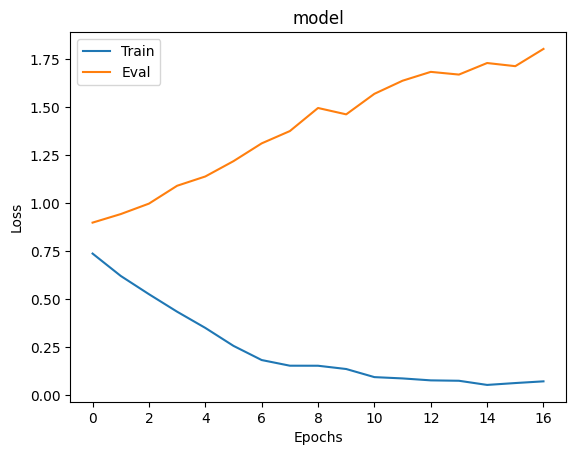

In [106]:
fig, ax = plt.subplots()
ax.set_title("model")
ax.plot(loss_train[1:], label="Train")
ax.plot(loss_eval[1:], label="Eval")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Reloading our model.

In [ ]:
model.load_state_dict(recover["model"])

Setting up the device we're running.

In [107]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Making prediction in our test dataset.

In [108]:
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for step in range(len(test_idx)):
        batch = val_idx.iloc[step]
        input_ids = batch["text"]["input_ids"].to(device)
        token_type_ids = batch["text"]["token_type_ids"].to(device)
        attention_mask = batch["text"]["attention_mask"].to(device)

        output = model(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        res = output.logits.cpu()
        ytrue += batch["labels"]
        lres += res

Setting our predictions list for comparison.

In [111]:
pred = [x.argmax(dim=0).cpu().tolist() for x in lres]

Printing our model "Real" metrics with a confusion matrix for better visualization.

                       model Metrics

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        20
           1       0.55      0.79      0.65        14
           2       0.68      0.61      0.64        41

    accuracy                           0.61        75
   macro avg       0.59      0.63      0.60        75
weighted avg       0.62      0.61      0.61        75

Accuracy score  =  0.6133333333333333
Precision score =  0.6201841841841842
Recall score    =  0.6133333333333333



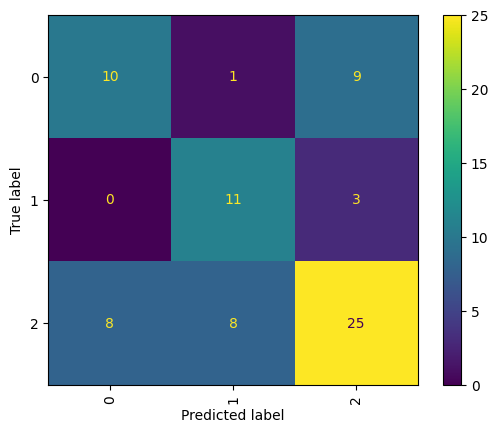

In [112]:
print("                       model Metrics")
print()
print(metrics.classification_report(ytrue, pred))
print("Accuracy score  = ", metrics.accuracy_score(ytrue, pred))
print("Precision score = ", metrics.precision_score(ytrue, pred, average="weighted"))
print("Recall score    = ", metrics.recall_score(ytrue, pred, average="weighted"))
print()
confusionmatrix = metrics.confusion_matrix(ytrue, pred)
confusion = metrics.ConfusionMatrixDisplay(confusionmatrix)
confusion.plot(xticks_rotation="vertical")